## genalg_1

In [14]:
include("todev.jl"); todev()
include("../shared/tomdcode.jl")

tomdcode (generic function with 1 method)

In [19]:
md"### The `genalg_1` module:"|>display
tomdcode("src/genalg_1.jl")

### The `genalg_1` module:


```julia
module genalg_1
  using StatsBase, DataStructures, Distributions
  # num of vars
  const NVAR = 5

  # the type for chromosomes
  mutable struct TCHROM
    arr::Vector{Float64}
    obj::Float64
  end

  # the function to be minimized
  obj(x) = sum(x .^ 2)
  obj!(x::TCHROM) = x.obj = obj(x.arr)

  # lower and upper bound 4 the vars
  const LB, UB = -10, 10

  # during the mutate event the variables/coordinates can leave the domain, 
  # this adjust back them
  # scalar variant
  adjust(x) = min(UB, max(LB, x))

  function adjust!(x::TCHROM)
    x.arr .= adjust.(x.arr)
  end


  SIGMUT = 0.1#*(UB - LB)
  mutdist = Normal(0, SIGMUT)
  mutstep() = rand(mutdist)
  mutate(x) = adjust(x + mutstep())

  # prob of mutation
  const PMUT = 0.2
  function mutate!(x::TCHROM)
    IDX = (1:NVAR)[rand(NVAR).<PMUT]
    x.arr[IDX] = mutate.(x.arr[IDX])
  end

  function cross!(p1::TCHROM, p2::TCHROM, c1::TCHROM, c2::TCHROM)
    for i = 1:NVAR
      c1.arr[i], c2.arr[i] = if rand() < 0.5
        p1.arr[i], p2.arr[i]
      else
        p2.arr[i], p1.arr[i]
      end
    end
  end

  # random chromosome
  choose(; n = 1) = rand(Uniform(LB, UB), n)
  choose(TCHROM) = (arr = choose(; n = NVAR); TCHROM(arr, obj(arr)))

  const POP_SIZE = 20
  const OFF_PROP = 1.0
  const OFF_SIZE = (((POP_SIZE * OFF_PROP) |> ceil |> Int) ÷ 2) * 2
  # reversing the obj values (to be able to use the weighted `sample`, 
  # smaller obj -> larger prob. of choosing)
  const BETA = 1.0

  function selection(pool, POP, OFF)
    w = Weights([exp(-POP[i].obj) for i = 1:POP_SIZE])
    idx = sample(1:POP_SIZE, w, OFF_SIZE; replace = true)
    for i = 1:2:OFF_SIZE
      p1, p2 = POP[idx[i]], POP[idx[i+1]]
      c1, c2 = OFF[i], OFF[i+1]
      cross!(p1, p2, c1, c2)
      mutate!(c1)
      obj!(c1)
      mutate!(c2)
      obj!(c2)
    end
    sort!(pool; by = x -> x.obj)

    pool[1]
  end

  const MAX_STEP = 500
  # the process will stop at `step` if gbest[step] and gbest[step-idle+1] close to each other (no improvement in the last `idle` length interval)	
  const STOP = (idle = min(30, floor(0.1 * MAX_STEP)) |> Int, tol = 1e-4)

  parstr = """POP_SIZE=$(POP_SIZE) OFF_SIZE=$(OFF_SIZE) MAX_STEP=$(MAX_STEP)
    PMUT=$(PMUT) SIGMUT=$(SIGMUT) BETA=$(BETA)"""

  function ga1()
    trace = Float32[]
    gbest = choose(TCHROM)
    gbest.obj = Inf

    tail = CircularBuffer{Float64}(STOP.idle)
    for i = 1:STOP.idle
      push!(tail, Inf)
    end

    status = ("MAX_STEP", MAX_STEP)
    pool_size = (POP_SIZE + OFF_SIZE)
    pool = [choose(TCHROM) for k = 1:pool_size]

    POP = view(pool, 1:POP_SIZE)
    OFF = view(pool, (POP_SIZE+1):pool_size)

    for step = 1:MAX_STEP
      lbest = selection(pool, POP, OFF)

      #println(POP)


      if lbest.obj < gbest.obj
        gbest = deepcopy(lbest)
      end
      push!(trace, gbest.obj)

      push!(tail, gbest.obj)
      if last(tail) + STOP.tol > first(tail)
        status = ("IDLE", step)
        break
      end
    end # of main loop
    gbest, status, trace, parstr

  end
  export ga1

end # of module

```


In [16]:
md"### The client code:"|>display
tomdcode("main.jl")

### The client code:


```julia
using genalg_1
using CairoMakie

@time (best,status,trace,parstr)=ga1()
println(best,"\n",status)
set_theme!(theme_dark())
update_theme!(;Axis=(;title=parstr),resolution=(800,600))
lines(trace)

```


### The output:


  0.004014 seconds (56.98 k allocations: 2.682 MiB)
genalg_1.TCHROM([6.901784728170768e-5, 0.0029784698303553653, 0.001064776617095975, 0.003879689788215915, 0.001101880985441641], 2.6275929796759563e-5)
("IDLE", 176)


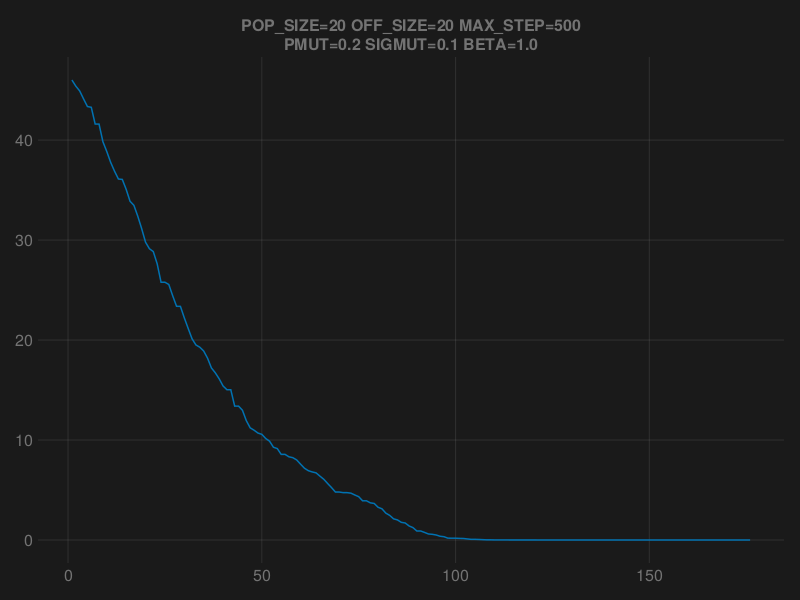

In [18]:
md"### The output:"|>display
include("main.jl")